In [85]:
import os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from torchmetrics.functional import accuracy as ACC

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence
from torchsummary import summary

import time
import nltk
import json
import random
import unicodedata
import contractions
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore")

#data cleaning methods
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [82]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [83]:
def Preprocessing(x):
    def removeSpecialChars(x):
        x = re.sub(r'[^\w ]+', " ", x)
        x = ' '.join(x.split())
        return x

    def removeAccentedChars(x):
        x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return x

    def removeStopwords(x):
        return ' '.join([t for t in x.split() if t not in stopwords])

    def removeDupsChar(x):
        x = re.sub("(.)\\1{2,}", "\\1", x)
        return x

    def replacing_single_char(x):
        replacements  = {0:'zero', 1:'one', 2:'two', 3:'three', 4:'four', 
                         5:'five', 6:'six', 7:'seven', 8:'eight', 9:'nine', 
                        'n':'north','s':'south','e':'east','w':'west'}
        def replace(t):
            if t in replacements:
                return replacements[t]
            else:
                return None
        
        return ' '.join(list(filter(lambda x: x is not None, [replace(t) if len(t) == 1 else t for t in x.split()])))

    x = str(x).lower().replace('\\', '').replace('_', ' ')
#     x = removeStopwords(x)
    x = contractions.fix(x)  # update contractions
    x = removeDupsChar(x)
    x = removeAccentedChars(x)
    x = removeSpecialChars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    x = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', " ", x)  # punctuations, special chars
    x = re.sub(r'\s+', ' ', x) # Extra spaces
#     x = replacing_single_char(x)
    return x

In [86]:
class Load_Preprocess():
    def __init__(self):
        self.word2index = {}
        self.max_len = 0
        
        self.Label2num = {'Entailment': 1, "Contradiction": 0}

        self.train_df = self.Preprocess_df(pd.DataFrame.from_dict(self.load_Processed_Data(self.load_Processed_cTAKES('ctakes/Train_Statements_cTAKES_Processed.json'), 'train')), Train=True)
        self.val_df = self.Preprocess_df(pd.DataFrame.from_dict(self.load_Processed_Data(self.load_Processed_cTAKES('ctakes/Dev_Statements_cTAKES_Processed.json'), 'dev')))
        self.test_df = self.Preprocess_df(pd.DataFrame.from_dict(self.load_Processed_Data(self.load_Processed_cTAKES('ctakes/Test_Statements_cTAKES_Processed.json'), 'test')))
        
    def load_Processed_cTAKES(self, split):
        ctakes_tokens_path = split
        with open(ctakes_tokens_path) as json_file:
            ctakes_tokens = json.load(json_file)

        preferred_text_dict = dict()
        for i in range(len(ctakes_tokens)):
            cm_dict = ctakes_tokens[i]['clinical_mention']
            temp_list = []
            for key in cm_dict.keys():
                try:
                    temp_list.append(cm_dict[key][0]['preferredText'])
                except:
                    continue
            preferred_text_dict[ctakes_tokens[i]['UUID'][0]] = temp_list
        return preferred_text_dict

    def load_Processed_Data(self, ctakes, split):
        preferred_text = []
        statement = []
        trail1 = []
        trail2 = []
        section = []
        label = []
        
        with open(f"training_data/{split}" + ".json") as file:
            data = json.load(file)
            uuid_list = list(data.keys())

        for id in uuid_list:
            statement.append(data[id]['Statement'])
            if split != 'test':
                label.append(self.Label2num[data[id]['Label']])
            else:
                label.append(-1)
            section.append(data[id]['Section_id'])
        
            with open(f"training_data/CT json/{data[id]['Primary_id']}" + ".json") as file: 
                ct = json.load(file)
                trail1.append(self.join_list(ct[data[id]['Section_id']]))
                
            if data[id]['Type'] == "Comparison":  
                with open(f"training_data/CT json/{data[id]['Secondary_id']}" + ".json") as file:
                    ct = json.load(file)
                    trail2.append(self.join_list(ct[data[id]['Section_id']]))
            else:
                trail2.append("_")
                
            preferred_text.append(','.join(ctakes[id]))

        return {'preferred_text':preferred_text, 'statement':statement, 'trail1':trail1, 'trail2':trail2, 'section':section, 'label':label}
        
    def join_list(self, sentences):
        return ", ".join([sent.strip() for sent in sentences])
    
    def Preprocess_df(self, df, Train=False):
        df['statement'] = df['statement'].apply(Preprocessing)
        df['trail1'] = df['trail1'].apply(Preprocessing)
        df['trail2'] = df['trail2'].apply(Preprocessing)

        df["#Words1"] = df["statement"].apply(lambda n: len(n.split()))
        df["#Words2"] = df["trail1"].apply(lambda n: len(n.split()))
        df["#Words3"] = df["trail2"].apply(lambda n: len(n.split()))
        
        if Train:
            self.Build_Vocabulary(df['statement'].tolist()+df['trail1'].tolist()+df['trail2'].tolist())
        return df

    def Build_Vocabulary(self, texts):
        words = ['', 'UNK']+list(set(' '.join(texts).split()))
        self.word2index = dict(zip(words, list(range(0, len(words)))))
        self.max_len = self.get_max_length(texts)
   
    def get_max_length(self, Texts):
        lens = [len(text.split(' ')) for text in Texts]
        print('index', lens.index(max(lens)))
        return max(lens)
    
    def Target_proportions(self, df):
        print(df.label.value_counts())
        sns.countplot(x=df['label']).set_title('Proportions of 0 vs 1')
        plt.show()

Data = Load_Preprocess()

index 2170


In [58]:
Data.max_len, len(Data.word2index)

(1583, 7220)

In [59]:
Data.val_df

,preferred_text,statement,trail1,trail2,section,label,#Words1,#Words2,#Words3
0,Primary operation,there is a 13 2 difference between the results...,outcome measurement event free survival event ...,,Results,0,16,127,0
1,"Ejection as a Sports activity,Primary operation",patients with significantly elevated ejection ...,inclusion criteria inclusion criteria female p...,premenopausal women 55 years of age or younger...,Eligibility,0,30,300,346
2,"Enterocolitis,Primary operation",a significant number of the participants in th...,adverse events 1 total 20 167 11 98 cardiac fa...,adverse events 1 total 112 458 24 45 febrile n...,Adverse Events,0,17,142,128
3,Primary operation,the primary trial does not report the pfs or o...,outcome measurement local control using ipsila...,,Results,1,16,88,0
4,"Therapeutic procedure,fulvestrant",prior treatment with fulvestrant or with a pho...,inclusion criteria postmenopausal women with h...,,Eligibility,0,23,404,0
...,...,...,...,...,...,...,...,...,...
195,"Oral cavity,Primary operation,Pharmaceutical P...",the the primary trial intervention involves on...,intervention 1 letrozole participants received...,intervention 1 sentinel lymph node biopsy not ...,Intervention,0,21,22,8
196,"Conjunctivitis,Primary operation",the secondary trial reported 1 single case of ...,adverse events 1 total 16 48 33 33 febrile neu...,adverse events 1 total 21 519 4 05 anaemia 1 5...,Adverse Events,1,17,71,148
197,Primary operation,the secondary trial and the primary trial do n...,outcome measurement number of patients with pa...,outcome measurement disease free survival time...,Results,1,17,222,118
198,"Worse,Disease,Primary operation",the outcome measurement of the primary trial i...,outcome measurement progression free survival ...,,Results,1,30,184,0


In [61]:
Data.train_df.shape, Data.val_df.shape, Data.test_df.shape

((1700, 9), (200, 9), (5500, 9))

In [62]:
Data.val_df.head()

,preferred_text,statement,trail1,trail2,section,label,#Words1,#Words2,#Words3
0,Primary operation,there is a 13 2 difference between the results...,outcome measurement event free survival event ...,,Results,0,16,127,0
1,"Ejection as a Sports activity,Primary operation",patients with significantly elevated ejection ...,inclusion criteria inclusion criteria female p...,premenopausal women 55 years of age or younger...,Eligibility,0,30,300,346
2,"Enterocolitis,Primary operation",a significant number of the participants in th...,adverse events 1 total 20 167 11 98 cardiac fa...,adverse events 1 total 112 458 24 45 febrile n...,Adverse Events,0,17,142,128
3,Primary operation,the primary trial does not report the pfs or o...,outcome measurement local control using ipsila...,,Results,1,16,88,0
4,"Therapeutic procedure,fulvestrant",prior treatment with fulvestrant or with a pho...,inclusion criteria postmenopausal women with h...,,Eligibility,0,23,404,0


In [64]:
Data.max_len, len(Data.word2index)

(1583, 7220)

In [80]:
Data.word2index

{'': 0,
 'UNK': 1,
 't3': 2,
 'boyd': 3,
 'aggravated': 4,
 'propafenone': 5,
 'teaes': 6,
 'dpd': 7,
 'mouse': 8,
 'recover': 9,
 '080': 10,
 'accrual': 11,
 'evista': 12,
 'cabozantinib': 13,
 'advanced': 14,
 'below': 15,
 'unborn': 16,
 'graded': 17,
 'volunteer': 18,
 'assesses': 19,
 'wellness': 20,
 'normalization': 21,
 '60': 22,
 'coexisting': 23,
 'solution': 24,
 'inherit': 25,
 'fungal': 26,
 'compliance': 27,
 'motor': 28,
 'egf': 29,
 'feasibility': 30,
 'progressions': 31,
 'antigens': 32,
 '103': 33,
 'polymorphism': 34,
 'genders': 35,
 'nivolumab': 36,
 'fluocinonide': 37,
 'psychotic': 38,
 'n': 39,
 'european': 40,
 '2013': 41,
 '458': 42,
 'stenting': 43,
 'inguinal': 44,
 'another': 45,
 'carboplatin': 46,
 'coordinator': 47,
 'concentrations': 48,
 'next': 49,
 'peritoneum': 50,
 '8201a': 51,
 'rd': 52,
 'compound': 53,
 'necessary': 54,
 'blockers': 55,
 'glycemic': 56,
 'defining': 57,
 'mlo': 58,
 'augmentation': 59,
 'lignans': 60,
 'proximally': 61,
 'everol

In [69]:
np.argmin([len(text.split()) for text in Data.train_df['statement'].tolist()+Data.train_df['trail1'].tolist()])

2193

In [70]:
texts = [text for text in Data.train_df['statement'].tolist()+Data.train_df['trail1'].tolist()+Data.train_df['trail2'].tolist()]
texts[2193]

'intervention 1 maestro baseline'

<Axes: >

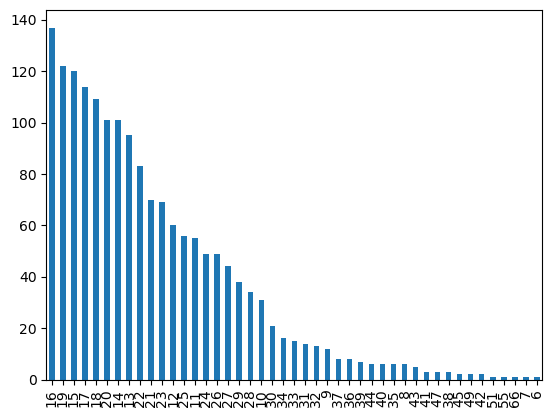

In [71]:
Data.train_df["#Words1"].value_counts().plot(kind='bar')

In [74]:
min(Data.train_df["#Words1"].to_numpy()), min(Data.train_df["#Words2"].to_numpy()), min(Data.train_df["#Words3"].to_numpy())

(6, 4, 0)

In [90]:
max(Data.train_df["#Words1"].to_numpy()), max(Data.train_df["#Words2"].to_numpy()), max(Data.train_df["#Words3"].to_numpy())

(66, 1583, 1405)

0    100
1    100
Name: label, dtype: int64


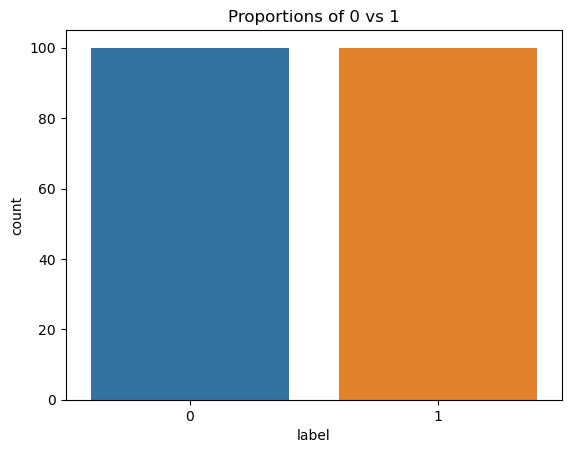

In [88]:
Data.Target_proportions(Data.val_df)

In [89]:
np.array([key for key in list(Data.word2index.keys()) if len(key)==2]), Data.word2index['zero']

(array(['t3', '60', 'rd', 'do', 'b1', 'dp', 'to', 'cr', 'ib', 'pa', 'vg',
        'bp', '64', 'pr', 'dl', 'bi', 'mi', 'nk', '06', '27', 'hi', '36',
        'gu', '25', 're', 'id', '15', '23', '3x', '4d', '44', 'od', 'hg',
        'l2', '53', '50', '93', '37', 'ps', 'my', '2b', 'md', '3a', 'of',
        '07', 'pk', '49', '84', 'ms', 'tv', 'gp', '01', '22', 'pn', '83',
        'a1', '39', '85', 't0', '26', 'n3', '2d', 'hz', 'g5', '19', 'a3',
        '57', 'sd', 'fl', 'ic', 'cd', 'm3', 'ua', 'za', 'pc', 'ki', '35',
        '16', 'uk', 'pp', 'he', 'os', '14', 'hb', '1p', 'mk', '66', 'pt',
        'v3', 'xi', '86', 'el', '96', 'iv', '13', 'fu', '73', 'kg', '47',
        '76', '91', 'mm', '87', 'bl', '82', '67', 'de', 'qt', '46', 'vi',
        'd2', 'wp', 'l1', 'et', 'er', 'll', 'da', 'hf', 'cm', '38', '48',
        '88', '72', 'tc', '7x', '40', 'sb', 't1', '97', 'rh', '3c', 'ct',
        'up', '42', 'so', '2x', '12', 'gi', 'as', '00', '11', '1c', 'ie',
        '65', '08', '54', '68', 'at', 

In [144]:
class SemEval_Dataset(Dataset):
    def __init__(self, Statment, Trial1, Trial2, Labels, word2index, max_len=[66, 1583, 1405]):
        
        self.Statment = Statment
        self.Trial1 = Trial1
        self.Trial2 = Trial2

        self.labels = Labels
        
        self.max_len = max_len
        self.word2index = word2index
        
    def Encode_Pad_seq(self, text, max_len_id):
        Encoded_text = [0]*self.max_len[max_len_id]
        for i, word in enumerate(text.split()):
            if word in self.word2index.keys():
                Encoded_text[i] = self.word2index[word]
            else:
                Encoded_text[i] = self.word2index['UNK']
            if i == self.max_len:
                break
        return Encoded_text, len(text.split())
    
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        S1, S2, S3, label = self.Statment[idx], self.Trial1[idx], self.Trial2[idx], self.labels[idx]
        
        x1, len1 = self.Encode_Pad_seq(S1, 0)
        x2, len2 = self.Encode_Pad_seq(S2, 1)
        x3, len3 = self.Encode_Pad_seq(S3, 2)

        return torch.LongTensor(np.array(x1)), torch.tensor(len1), torch.LongTensor(np.array(x2)), torch.tensor(len2), torch.LongTensor(np.array(x3)), torch.tensor(len3), torch.tensor(label)

train_dataset = SemEval_Dataset(Data.train_df['statement'].tolist(), Data.train_df['trail1'].tolist(), Data.train_df['trail2'].tolist(), Data.train_df['label'].tolist(), Data.word2index)
val_dataset = SemEval_Dataset(Data.val_df['statement'].tolist(), Data.val_df['trail1'].tolist(), Data.train_df['trail2'].tolist(), Data.val_df['label'].tolist(), Data.word2index)
test_dataset = SemEval_Dataset(Data.test_df['statement'].tolist(), Data.test_df['trail1'].tolist(), Data.train_df['trail2'].tolist(), Data.test_df['label'].tolist(), Data.word2index)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [145]:
train_dataset.__getitem__(0)

(tensor([4688, 7138,  216, 3418, 1363,   98, 2744, 1948, 4611, 6738, 3296, 6738,
         3882, 1100, 6707, 1493, 2048, 4794, 6262, 4688, 7138, 4279, 3418, 2083,
         1948,  341,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0]),
 tensor(26),
 tensor([1137, 6375, 4791,  ...,    0,    0,    0]),
 tensor(79),
 tensor([1137, 6375, 6425,  ...,    0,    0,    0]),
 tensor(100),
 tensor(0))

In [179]:
class SNLI_BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        
        super().__init__()
                                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
        self.dropout = nn.Dropout(0.3)

        self.translation = nn.Linear(embedding_dim, hidden_dim)
        
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, bidirectional=True, dropout=0.2, batch_first=True)
#         self.attention = Attention(hidden_dim)

#         self.fc1 = nn.Linear(hidden_dim * 2, 512) # CrossProduct(S1,S2)
        self.fc1 = nn.Linear(hidden_dim * 2 * 3, 512) # Concatenation of S1 and S2
#         self.fc1 = nn.Linear((hidden_dim * 2 * 2)+256, 512) # Concatenation of S1, S2, CrossProduct(S1,S2)

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        
        self.fc_out = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, stat, l1, trial1, l2, trial2, l3):      
        embedded_stat = self.embedding(stat)
        embedded_stat = self.dropout(embedded_stat)
        embedded_stat = F.relu(self.translation(embedded_stat))
        outputs_stat, (hidden_stat, cell_stat) = self.lstm(embedded_stat)

        embedded_trial1 = self.embedding(trial1)
        embedded_trial1 = self.dropout(embedded_trial1)
        embedded_trial1 = F.relu(self.translation(embedded_trial1))
        outputs_trial1, (hidden_trial1, cell_trial1) = self.lstm(embedded_trial1)
        
        embedded_trial2 = self.embedding(trial2)
        embedded_trial2 = self.dropout(embedded_trial2)
        embedded_trial2 = F.relu(self.translation(embedded_trial2))
        outputs_trial2, (hidden_trial2, cell_trial2) = self.lstm(embedded_trial2)
        
        hidden_stat = torch.cat((hidden_stat[-1], hidden_stat[-2]), dim=-1)
        hidden_trial1 = torch.cat((hidden_trial1[-1], hidden_trial1[-2]), dim=-1)
        hidden_trial2 = torch.cat((hidden_trial2[-1], hidden_trial2[-2]), dim=-1)

        out = torch.cat((hidden_stat, hidden_trial1, hidden_trial1), dim=-1) # 
#         out = hidden_prem * hidden_hypo # Cross product
#         out = torch.cat((hidden_prem, hidden_hypo, out), dim=-1)
    
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = F.relu(self.fc3(out))
        out = self.dropout(out)
        prediction = self.fc_out(out)
                
        return prediction
    
class SNLI_BiLSTM_var_Len(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        
        super().__init__()
                                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = 0)
        self.translation = nn.Linear(embedding_dim, hidden_dim)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, dropout=0.2, batch_first=True)
#         self.fc1 = nn.Linear(hidden_dim * 2, 512) # CrossProduct(S1,S2)
        self.fc1 = nn.Linear(hidden_dim * 2 * 3, 512) # Concatenation of S1 and S2
#         self.fc1 = nn.Linear((hidden_dim * 2 * 2)+256, 512) # Concatenation of S1, S2, CrossProduct(S1,S2)

        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        
        self.fc_out = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, stat, l1, trial1, l2, trial2, l3):
        embedded_stat = self.embedding(stat)
        embedded_stat = nn.utils.rnn.pack_padded_sequence(embedded_stat, l1.cpu(), batch_first=True, enforce_sorted=False)
        outputs_stat, (hidden_stat, cell_stat) = self.lstm(embedded_stat)

        embedded_trial1 = self.embedding(trial1)
        embedded_trial1 = nn.utils.rnn.pack_padded_sequence(embedded_trial1, l2.cpu(), batch_first=True, enforce_sorted=False)
        outputs_trial1, (hidden_trial1, cell_trial1) = self.lstm(embedded_trial1)
        
        embedded_trial2 = self.embedding(trial2)
        embedded_trial2 = nn.utils.rnn.pack_padded_sequence(embedded_trial2, l3.cpu(), batch_first=True, enforce_sorted=False)
        outputs_trial2, (hidden_trial2, cell_trial2) = self.lstm(embedded_trial2)

        hidden_stat = torch.cat((hidden_stat[-1], hidden_stat[-2]), dim=-1)
        hidden_trial1 = torch.cat((hidden_trial1[-1], hidden_trial1[-2]), dim=-1)
        hidden_trial2 = torch.cat((hidden_trial2[-1], hidden_trial2[-2]), dim=-1)

        
        out = torch.cat((hidden_stat, hidden_trial1, hidden_trial1), dim=-1) # 
#         out = hidden_prem * hidden_hypo # Cross product
#         out = torch.cat((hidden_prem, hidden_hypo, out), dim=-1)
    
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = F.relu(self.fc2(out))
        out = self.dropout(out)
        out = F.relu(self.fc3(out))
        out = self.dropout(out)
        prediction = self.fc_out(out)
                
        return prediction

In [180]:
class Text_Entailment(pl.LightningModule):
    def __init__(self, vocab_size, embedding_dim, hidden_dim) :
        super(Text_Entailment, self).__init__()
#         self.model = SNLI_BiLSTM(vocab_size, embedding_dim, hidden_dim)
        self.model = SNLI_BiLSTM_var_Len(vocab_size, embedding_dim, hidden_dim)
        self.CE = nn.CrossEntropyLoss()
        self.Faithfulness = nn.L1Loss()

    def forward(self, x1, l1, x2, l2, x3, l3):
        return self.model(x1, l1, x2, l2, x3, l3)

    def training_step(self, batch, batch_idx):
        x1, l1, x2, l2, x3, l3, y = batch
        y_hat = self.forward(x1, l1, x2, l2, x3, l3)
        
        probs = F.softmax(y_hat, dim=1)
        _, predicted_classes = torch.max(probs, dim=1)
            
        loss = self.CE(y_hat, y)
        self.log('Train_loss', loss, prog_bar=True, logger=True)
        
        acc = self.Faithfulness(predicted_classes.float(), y.float())
        self.log('Train_acc', acc, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x1, l1, x2, l2, x3, l3, y = batch
        y_hat = self.forward(x1, l1, x2, l2, x3, l3)
        
        loss = self.CE(y_hat, y)
        self.log('Val_loss', loss, prog_bar=True, logger=True)
        
        probs = F.softmax(y_hat, dim=1)
        _, predicted_classes = torch.max(probs, dim=1)
        
        acc = self.Faithfulness(predicted_classes.float(), y.float())
        self.log('Val_acc', acc, prog_bar=True)
        
        return loss

    def test_step(self, test_batch, batch_idx):
        x1, l1, x2, l2, x3, l3, y = test_batch
        y_hat = self.forward(x1, l1, x2, l2, x3, l3)
        loss = self.CE(y_hat, y)
        
        probs = F.softmax(y_hat, dim=1)
        _, predicted_classes = torch.max(probs, dim=1)

        acc = self.Faithfulness(predicted_classes.float(), y.float())
        
        self.log('test_loss', loss)
        self.log('test_acc', acc, prog_bar=True)

        print('Test_acc', acc)
    
    def predict_step(self, test_batch, batch_idx, dataloader_idx=None):
        with torch.no_grad():
            x1, l1, x2, l2, x3, l3, y = test_batch  # Assuming your input data is the first element of the batch
            logits = self.forward(x1, l1, x2, l2, x3, l3)  # Get logits from your model

            # Apply softmax to get probability distribution over classes
            probabilities = F.softmax(logits, dim=1)

            # Get class predictions by finding the class with the highest probability
            _, predicted_classes = torch.max(probabilities, dim=1)

        return predicted_classes.tolist()
    
#     def Faithfulness(self, y_hat, y):
#         assert y_hat.shape == y.shape
#         abs_diff = np.abs(y_hat - y)/y.shape[0]
#         return abs_diff

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [181]:
vocab_size = len(Data.word2index)
embedding_dim = 100
hidden_dim = 128

Model = Text_Entailment(vocab_size, embedding_dim, hidden_dim).to(device)
print(Model)

Text_Entailment(
  (model): SNLI_BiLSTM_var_Len(
    (embedding): Embedding(7220, 100, padding_idx=0)
    (translation): Linear(in_features=100, out_features=128, bias=True)
    (lstm): LSTM(100, 128, batch_first=True, dropout=0.2, bidirectional=True)
    (fc1): Linear(in_features=768, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc_out): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (CE): CrossEntropyLoss()
  (Faithfulness): L1Loss()
)


In [176]:
def get_pretrained_glove_vectors(vocab, root='C:/Users/35846/Desktop/Deep Learning Projects/Glove'):
    # url = 'http://nlp.stanford.edu/data/glove.6B.zip'
    # download_and_extract(url, root)
    
    embedding_dim = 100
    vectors = torch.zeros(len(vocab.keys()), embedding_dim)
    found = 0
    no_embed = []
    with open(f'{root}/glove.6B.{embedding_dim}d.txt', 'r', encoding="utf8") as f:
        for line in tqdm(f):
            token, *vector = line.split()
            if token in vocab.keys():
                found += 1
                vector = [float(v) for v in vector]
                vectors[vocab[token]] = torch.FloatTensor(vector)
            else:
                no_embed.append(token)
    print(f'{found/len(vocab)*100:.2f}% of vocab had a pre-trained embedding!')
    return vectors, no_embed

pretrained_vectors, no_embed = get_pretrained_glove_vectors(Data.word2index)


0it [00:00, ?it/s]
3415it [00:00, 33979.66it/s]
9188it [00:00, 47865.76it/s]
18484it [00:00, 68233.03it/s]
30690it [00:00, 89364.58it/s]
40715it [00:00, 93271.83it/s]
54024it [00:00, 106514.31it/s]
69338it [00:00, 121580.80it/s]
84937it [00:00, 132214.23it/s]
98245it [00:00, 132197.66it/s]
114136it [00:01, 140006.94it/s]
128134it [00:01, 139203.60it/s]
142053it [00:01, 137604.73it/s]
156781it [00:01, 140067.47it/s]
171156it [00:01, 140638.46it/s]
185222it [00:01, 138167.04it/s]
199048it [00:01, 135114.44it/s]
212700it [00:01, 135114.12it/s]
228683it [00:01, 142118.00it/s]
242916it [00:01, 140853.29it/s]
257855it [00:02, 142944.43it/s]
272163it [00:02, 142579.59it/s]
287768it [00:02, 146465.48it/s]
304451it [00:02, 152192.27it/s]
319681it [00:02, 148842.66it/s]
335567it [00:02, 151372.51it/s]
351098it [00:02, 152459.78it/s]
366359it [00:02, 145138.27it/s]
381503it [00:02, 146603.24it/s]
400000it [00:02, 133674.68it/s]

84.54% of vocab had a pre-trained embedding!


In [103]:
len(no_embed)

393896

In [182]:
Model.model.embedding.weight.data.copy_(pretrained_vectors)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.8764,  0.2643, -0.3254,  ..., -0.6425,  0.2861,  0.6296],
        ...,
        [ 0.0725, -0.1586, -0.3730,  ..., -0.2002, -0.6224,  0.4096],
        [-0.4527,  0.9526,  0.4424,  ...,  0.0189,  0.0202,  0.0712],
        [-0.2291, -0.2357,  0.0532,  ..., -0.5439,  0.2925, -0.4862]],
       device='cuda:0')

In [183]:
trainer = pl.Trainer(max_epochs=32)
trainer.fit(Model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                | Params
-----------------------------------------------------
0 | model        | SNLI_BiLSTM_var_Len | 1.5 M 
1 | CE           | CrossEntropyLoss    | 0     
2 | Faithfulness | L1Loss              | 0     
-----------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.115     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

RuntimeError: Length of all samples has to be greater than 0, but found an element in 'lengths' that is <= 0

In [178]:
trainer.test(Model, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Test_acc tensor(0.5050, device='cuda:0')
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5049999952316284
        test_loss           0.6983451843261719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6983451843261719, 'test_acc': 0.5049999952316284}]

In [183]:
predictions = trainer.predict(Model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [184]:
np.array(predictions[0])

array([2, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 2, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1,
       0, 2, 2, 1, 0, 0, 2, 1, 1, 2, 0, 0, 0, 1, 2, 1, 1, 0, 2, 1, 1, 2,
       2, 1, 2, 0, 2, 1, 2, 0, 1, 2, 1, 0, 0, 1, 2, 0, 1, 0, 2, 0, 2, 0,
       2, 1, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 0, 0, 0, 1, 2,
       0, 2, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 0, 0, 1, 0, 2,
       0, 2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 2, 1, 2, 0, 1, 2, 1, 1, 1, 2, 0,
       2, 0, 1, 2, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 0, 2, 2, 1, 0, 2, 1, 1,
       1, 0, 2, 2, 0, 2, 2, 1, 1, 2, 1, 0, 0, 2, 1, 0, 0, 0, 1, 2, 0, 1,
       0, 0, 1, 0, 1, 0, 2, 2, 0, 1, 1, 2, 1, 0, 2, 1, 0, 2, 1, 0, 1, 2,
       1, 1, 0, 2, 1, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 1,
       2, 2, 0, 1, 2, 0, 1, 1, 0, 2, 0, 2, 2, 2, 0, 1, 0, 1, 2, 1, 2, 0,
       2, 0, 1, 1, 2, 1, 2, 1, 0, 1, 0, 2, 2, 1])